In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.insert(0, "../func_py/")
import data_utils as dtu
import infer_gbm as gbm

In [2]:
def make_delta_logcount_hist(sp_counts_filtered, agg_label, n1_min, bins=15):
    
    mask = np.logical_and(sp_counts_filtered.n1 >= n1_min, sp_counts_filtered.n2 > 0)
    aux_fr = sp_counts_filtered[mask].copy()
    n1s = aux_fr['n1']
    aux_fr['logn1'] = np.where(n1s > 0, np.log(n1s), -1) 
    n2s = aux_fr['n2']
    aux_fr['logn2'] = np.where(n2s > 0, np.log(n2s, where=n2s>0), -1) 
    aux_fr['delta_log'] = aux_fr['logn2'] - aux_fr['logn1']
    delta_ser = aux_fr.groupby('delta_log').agg({agg_label : sum})
    delta_uni, delta_counts = delta_ser.index.values, delta_ser[agg_label].values
    
    if type(bins) == int:
        bins_mid = np.linspace(min(delta_uni), max(delta_uni), bins)
        dbin = bins_mid[1] - bins_mid[0]
        bins = np.append(bins_mid - 0.5*dbin, bins_mid[-1] + 0.5*dbin)
    else:
        bins_mid = (bins[1:] + bins[:-1]) / 2.0
        
    bin_counts = np.zeros(len(bins_mid))
    for i in range(len(bins_mid)):
        mask = np.logical_and(delta_uni > bins[i], delta_uni <= bins[i+1])
        bin_counts[i] = delta_counts[mask].sum()
        
    return bins_mid, bin_counts


def compute_pn2(sp_counts, agg_label):
    n2_counts = sp_counts.groupby('n2').agg({agg_label : sum})
    n2s = n2_counts.index.values
    vals = (n2_counts[agg_label]/n2_counts[agg_label].sum()).values
    n2s = np.array(n2s, dtype=float)
    if n2s[0] == 0:
        n2s[0] = 0.5
    return n2s, vals


def compute_pn2_at_conditions(sp_counts, n1_cond, agg_label):
    n2_counts = sp_counts[n1_cond].groupby('n2').agg({agg_label : sum})
    n2_counts = n2_counts.sort_values('n2')
    p_n2 = n2_counts[agg_label].values / n2_counts[agg_label].values.sum()
    return np.array(n2_counts.index.values, dtype=float), p_n2


def compute_pn3_at_conditions(sp_counts, n1_cond, n2_cond, agg_label):
    mask = np.logical_and(n1_cond(sp_counts), n2_cond(sp_counts))
    n3_counts = sp_counts[mask].groupby('n3').agg({agg_label : sum})
    n3_counts = n3_counts.sort_values('n3')
    p_n3 = n3_counts[agg_label].values / n3_counts[agg_label].values.sum()
    return np.array(n3_counts.index.values, dtype=float), p_n3

In [3]:
metadata = pd.read_csv('metadata/metadata.tsv', sep='\t', index_col=0)

pairs_and_dts = [
    ('1', ('pat1_t1_mc', 'pat1_t2_mc'), [10], [5,5]),
    ('2_2', ('pat2_t1_mc', 'pat2_t2_mc'), [6], [4,4]),
    ('2_3', ('pat2_t1_mc', 'pat2_t2_mc', 'pat2_t3_mc'), [6, 1/6], [4,4])
]
pairs_and_dts

[('1', ('pat1_t1_mc', 'pat1_t2_mc'), [10], [5, 5]),
 ('2_2', ('pat2_t1_mc', 'pat2_t2_mc'), [6], [4, 4]),
 ('2_3',
  ('pat2_t1_mc', 'pat2_t2_mc', 'pat2_t3_mc'),
  [6, 0.16666666666666666],
  [4, 4])]

## Fitting marginals of two time points of patinet 2

### Distribution of delta log-counts

In [6]:
label, samples, dtimes, priors = pairs_and_dts[1]

# Importing data and inferred parameters
sp_counts = dtu.import_and_build_sparse_counts(samples)
sp_counts_filter = sp_counts[sp_counts.n1 >= 1]
pars = dtu.read_pars('inference/gbm/pat'+label+'_nmin1.txt')
alpha = 2 * pars['theta'] / pars['tau']

In [9]:
pars['M_tot'] = 10**8
pars['n0'] = 10**(np.log10(pars['M_tot']) + pars['logM_logn0_offset_slope1'])

In [11]:
# Computing the probability of observing the counts given the best parameters
max_n = 30
infer_pars = gbm.gbm_infer_pars(dtimes, pars['M_tot'], pars['n0'], 1, n_eval=10**6, prior_pars=priors)
probs = gbm.compute_sp_count_probs(sp_counts, pars['tau'], pars['theta'], infer_pars, max_n)

# Computing the probabilities given the wrong parameters
alt_ls = ['--', '-.']
alt_cols = ['#8e82fe', '#9e3623']
alt_taus = [3, 70]
alt_probs = []
for t in alt_taus:
    theta = t * alpha / 2.0
    alt_probs.append(gbm.compute_sp_count_probs(sp_counts, t, theta, infer_pars, max_n))

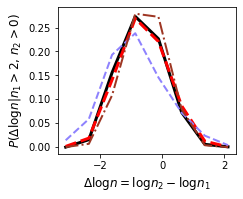

In [12]:
bins = np.linspace(-3.5, 2.5, 9)
n1_min_dlog = 3
bins_mid, bin_counts = make_delta_logcount_hist(sp_counts_filter, 'occ', n1_min_dlog, bins=bins)
bins_mid_th, bin_p_th = make_delta_logcount_hist(probs, 'prob', n1_min_dlog, bins=bins)
bin_p_th_alt = []
for k in range(len(alt_taus)):
    _, _bin_p = make_delta_logcount_hist(alt_probs[k], 'prob', n1_min_dlog, bins=bins)
    bin_p_th_alt.append(_bin_p)

plt.figure(figsize=(3.2, 2.7))
plt.ylabel(r"$P(\Delta \log n | n_1 > $"+str(n1_min_dlog-1)+", $ n_2>0)$", fontsize=12)
plt.xlabel(r"$\Delta \log n = \log n_2 - \log n_1$", fontsize=12)
plt.plot(bins_mid, bin_counts / bin_counts.sum()*(bins[1]-bins[0]), lw=3, label='data', c='k')
l = r'best $\tau=%3.2f$'%pars['tau']
plt.plot(bins_mid_th, bin_p_th / bin_p_th.sum()*(bins[1]-bins[0]), lw=3, c='r', label=l, ls='--')

for k in range(len(alt_taus)):
    l = r'wrong $\tau=%3.2f$'%alt_taus[k]
    plt.plot(bins_mid_th, bin_p_th_alt[k] / bin_p_th_alt[k].sum()*(bins[1]-bins[0]), 
             label=l, lw=2, ls=alt_ls[k], c=alt_cols[k])
    
#plt.legend(fontsize=10)
#plt.savefig('plots/gbm/marginals/p_delta_logn_pat'+label+'_nmin1.svg', facecolor='w')

### Distribution of counts at a given time point

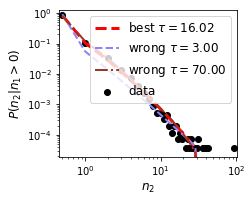

In [13]:
n2s, p_n2_data = compute_pn2(sp_counts_filter, 'occ')
n2s_th, p_n2_th = compute_pn2(probs, 'prob')
p_n2_alt = []
for k in range(len(alt_taus)):
    p_n2_alt.append(compute_pn2(alt_probs[k], 'prob')[1])
    
plt.figure(figsize=(3.2, 2.7))
plt.loglog()
plt.ylabel(r"$P(n_2 | n_1 > 0)$", fontsize=12)
plt.xlabel(r"$n_2$", fontsize=12)
plt.xlim(np.min(n2s)*0.9, np.max(n2s)*1.1)
plt.ylim(np.min(p_n2_data)*0.5, np.max(p_n2_data)*1.5)

plt.scatter(n2s, p_n2_data, c='k', label='data')
l = r'best $\tau=%3.2f$'%pars['tau']
plt.plot(n2s_th, p_n2_th, c='r', lw=3, ls='--', label=l)
for k in range(len(alt_taus)):
    l = r'wrong $\tau=%3.2f$'%alt_taus[k]
    plt.plot(n2s_th, p_n2_alt[k], lw=2, ls=alt_ls[k], c=alt_cols[k], label=l)
plt.legend(fontsize=12)

#plt.savefig('plots/gbm/marginals/p_n2_pat'+label+'_nmin1.svg', facecolor='w')

### Distribution of counts at time 2 conditioned to counts at time 1 to be larger or smaller than a value

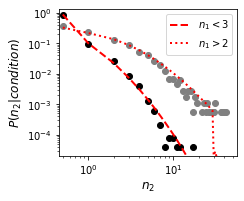

In [14]:
k = 3
cond = lambda sp : sp.n1 < k
n2s, p_n2_data = compute_pn2_at_conditions(sp_counts_filter, cond, 'occ')
n2s_th, p_n2_th = compute_pn2_at_conditions(probs, cond, 'prob')
n2s_th[0] = 0.5
n2s[0] = 0.5

plt.figure(figsize=(3.2, 2.7))
plt.loglog()
plt.ylabel(r"$P(n_2 | condition)$", fontsize=12)
plt.xlabel(r"$n_2$", fontsize=12)

plt.scatter(n2s, p_n2_data, c='k')
plt.ylim(np.min(p_n2_data)*0.5, np.max(p_n2_data)*1.5)
plt.plot(n2s_th, p_n2_th, c='r', lw=2, ls='--', label=r'$n_1 < $'+str(k))

k = 2
cond = lambda sp : sp.n1 > k
n2s, p_n2_data = compute_pn2_at_conditions(sp_counts_filter, cond, 'occ')
n2s_th, p_n2_th = compute_pn2_at_conditions(probs, cond, 'prob')
n2s_th[0] = 0.5
n2s[0] = 0.5

plt.scatter(n2s, p_n2_data, c='gray')
plt.xlim(np.min(n2s)*0.9, np.max(n2s)*0.6)
plt.plot(n2s_th, p_n2_th, c='r', lw=2, ls=':', label=r'$n_1 > $'+str(k))
plt.legend()

#plt.savefig('plots/gbm/marginals/p_n2_ineq_pat'+label+'_nmin1.svg', facecolor='w')

### Distribution of counts at time 2 conditioned to counts at time 1 to be equal to a value

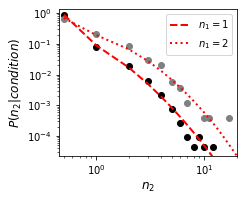

In [15]:
k = 1
cond = lambda sp : sp.n1 == k
n2s, p_n2_data = compute_pn2_at_conditions(sp_counts_filter, cond, 'occ')
n2s_th, p_n2_th = compute_pn2_at_conditions(probs, cond, 'prob')
n2s_th[0] = 0.5
n2s[0] = 0.5

plt.figure(figsize=(3.2, 2.7))
plt.loglog()
plt.ylabel(r"$P(n_2 | condition)$", fontsize=12)
plt.xlabel(r"$n_2$", fontsize=12)

plt.scatter(n2s, p_n2_data, c='k')
#plt.xlim(np.min(n3s)*0.9, np.max(n3s)*1.1)
plt.ylim(np.min(p_n2_data)*0.5, np.max(p_n2_data)*1.5)
plt.plot(n2s_th, p_n2_th, c='r', lw=2, ls='--', label=r'$n_1 = $'+str(k))

k = 2
cond = lambda sp : sp.n1 == k
n2s, p_n2_data = compute_pn2_at_conditions(sp_counts_filter, cond, 'occ')
n2s_th, p_n2_th = compute_pn2_at_conditions(probs, cond, 'prob')
n2s_th[0] = 0.5
n2s[0] = 0.5

plt.scatter(n2s, p_n2_data, c='gray')
plt.xlim(np.min(n2s)*0.9, np.max(n2s)*1.2)
#plt.ylim(np.min(p_n2_data)*0.5, np.max(p_n2_data)*1.5)
plt.plot(n2s_th, p_n2_th, c='r', lw=2, ls=':', label=r'$n_1 = $'+str(k))
plt.legend()

#plt.savefig('plots/gbm/marginals/p_n2_eq_pat'+label+'_nmin1.svg', facecolor='w')

## Predicting marginals of pat2 at time 3
This generalizes the inference computed at the first two time points

In [17]:
label3, samples3, dtimes3, priors3 = pairs_and_dts[2]
label2, samples2, dtimes2, priors2 = pairs_and_dts[1]
n_min = 1

# Importing data and inferred parameters
sp_counts3 = dtu.import_and_build_sparse_counts(samples3)
sp_counts3_filter = sp_counts3[sp_counts3.n1 >= n_min]
pars2 = dtu.read_pars('inference/gbm/pat'+label2+'_nmin1_exe.txt')
alpha = 2 * pars2['theta'] / pars2['tau']

In [109]:
# Computing the probability of observing the counts for 3 time points given the best parameters at 2
max_n = 35
infer_pars = gbm.gbm_infer_pars(dtimes3, pars2['M_tot'], pars2['n0'], n_min, n_eval=10**6, prior_pars=priors2)
%time probs = gbm.compute_sp_count_probs(sp_counts3, pars2['tau'], pars2['theta'], infer_pars, max_n)

CPU times: user 9min 50s, sys: 375 ms, total: 9min 50s
Wall time: 9min 50s


### Conditioning with greater than - smaller than

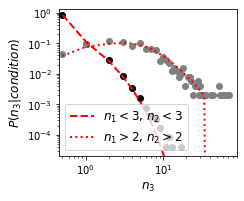

In [112]:
k = 3
cond1, cond2 = lambda sp : sp.n1 < k, lambda sp : sp.n2 < k
n3s, p_n3_data = compute_pn3_at_conditions(sp_counts3_filter, cond1, cond2, 'occ')
n3s_th, p_n3_th = compute_pn3_at_conditions(probs, cond1, cond2, 'prob')
n3s_th[0] = 0.5
n3s[0] = 0.5

plt.figure(figsize=(3.2, 2.7))
plt.loglog()
plt.ylabel(r"$P(n_3 | condition)$", fontsize=12)
plt.xlabel(r"$n_3$", fontsize=12)

plt.scatter(n3s, p_n3_data, c='k')
#plt.xlim(np.min(n3s)*0.9, np.max(n3s)*1.1)
plt.ylim(np.min(p_n3_data)*0.5, np.max(p_n3_data)*1.5)
plt.plot(n3s_th, p_n3_th, c='r', lw=2, ls='--', label=r'$n_1 < $'+str(k)+r', $n_2 <$'+str(k))


k = 2
cond1, cond2 = lambda sp : sp.n1 > k, lambda sp : sp.n2 > k
n3s, p_n3_data = compute_pn3_at_conditions(sp_counts3_filter, cond1, cond2, 'occ')
n3s_th, p_n3_th = compute_pn3_at_conditions(probs, cond1, cond2, 'prob')
n3s_th[0] = 0.5
n3s[0] = 0.5

plt.scatter(n3s, p_n3_data, c='gray')
plt.xlim(np.min(n3s)*0.9, np.max(n3s)*0.5)
#plt.ylim(np.min(p_n3_data)*0.5, np.max(p_n3_data)*1.5)
plt.plot(n3s_th, p_n3_th, c='r', lw=2, ls=':', label=r'$n_1>$'+str(k)+r', $n_2>$'+str(k))
plt.legend(fontsize=12)

#plt.savefig('plots/gbm/marginals/p_n3_ineq_pat'+label+'_nmin1.svg', facecolor='w')

### Conditioning with equality

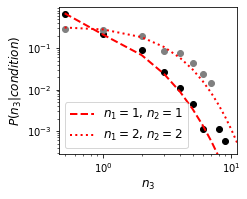

In [113]:
k = 1
cond1, cond2 = lambda sp : sp.n1 == k, lambda sp : sp.n2 == k
n3s, p_n3_data = compute_pn3_at_conditions(sp_counts3_filter, cond1, cond2, 'occ')
n3s_th, p_n3_th = compute_pn3_at_conditions(probs, cond1, cond2, 'prob')
n3s_th[0] = 0.5
n3s[0] = 0.5

plt.figure(figsize=(3.2, 2.7))
plt.loglog()
plt.ylabel(r"$P(n_3 | condition)$", fontsize=12)
plt.xlabel(r"$n_3$", fontsize=12)

plt.scatter(n3s, p_n3_data, c='k')
#plt.xlim(np.min(n3s)*0.9, np.max(n3s)*1.1)
plt.ylim(np.min(p_n3_data)*0.5, np.max(p_n3_data)*1.5)
plt.plot(n3s_th, p_n3_th, c='r', lw=2, ls='--', label=r'$n_1=$'+str(k)+r', $n_2=$'+str(k))

k=2
cond1, cond2 = lambda sp : sp.n1 == k, lambda sp : sp.n2 == k
n3s, p_n3_data = compute_pn3_at_conditions(sp_counts3_filter, cond1, cond2, 'occ')
n3s_th, p_n3_th = compute_pn3_at_conditions(probs, cond1, cond2, 'prob')
n3s_th[0] = 0.5
n3s[0] = 0.5

plt.scatter(n3s, p_n3_data, c='gray')
plt.xlim(np.min(n3s)*0.9, np.max(n3s)*1.6)
#plt.ylim(np.min(p_n3_data)*0.5, np.max(p_n3_data)*1.5)
plt.plot(n3s_th, p_n3_th, c='r', lw=2, ls=':', label=r'$n_1=$'+str(k)+r', $n_2=$'+str(k))
plt.legend(fontsize=12)

plt.savefig('plots/gbm/marginals/p_n3_eq_pat'+label+'_n1min_'+str(n_min)+'.svg', facecolor='w')

## First passage time quantities

In [18]:
def fpt_GBM(x0, t, tau, theta):
    return x0 * np.sqrt(theta/2/np.pi/t**3) * np.exp(-theta/2/t*(x0 - t/tau)**2)

        
def stat_dist(x, tau, alpha, n0):
    x0 = np.log(n0)
    coef = 1 / x0
    return np.where(x < x0, coef * (1 - np.exp(-alpha*x)), coef * (np.exp(alpha*(x0-x)) - np.exp(-alpha*x)))


def p_n(n, tau, theta, n0, M_tot, M_exp, n_points=5000):
    xs = np.linspace(0, np.log(M_tot), n_points)
    alpha = 2*theta/tau
    stat = stat_dist(xs, tau, alpha, n0)
    noise = gbm.poisson(np.exp(xs)*M_exp/M_tot).pmf(n)
    return np.sum(stat*noise) * (xs[1]-xs[0])


def ftp_GBM_noise(n, t, tau, theta, n0, M_tot, M_exp, n_points=5000):
    xs = np.linspace(0, np.log(M_tot), n_points)
    stat = stat_dist(xs, tau, alpha, n0)
    noise = gbm.poisson(np.exp(xs)*M_exp/M_tot).pmf(n)
    fpt = fpt_GBM(xs, t, tau, theta)
    return np.sum(stat*noise*fpt) * (xs[1]-xs[0])

def p_ext(n, t, tau, theta, n0, M_tot, M_exp, n_points_x=1000, n_points_t=1000):
    ts = np.linspace(0, t, n_points_t)
    
    
def prop_GBM_noabs(x1, x2, t, tau, theta):
    return np.sqrt(theta/2/np.pi/t) * np.exp(-theta/2/t*(x2 - x1 + t/tau)**2)


def prop_GBM(x1, x2, t, tau, theta):
    prop1 = prop_GBM_noabs(x1, x2, t, tau, theta)
    prop2 = prop_GBM_noabs(-x1, x2, t, tau, theta)
    alpha = 2*theta/tau
    return prop1 - np.exp(-alpha*t) * prop2 # Not normalized, we exclude x2=0 that doesn't count later


def p_exp_surv_GBM(n1, t, tau, theta, n0, M_tot, M_exp, n_points=500):
    xs = np.linspace(0, np.log(M_tot), n_points)
    dx = xs[1]-xs[0]
    stat = stat_dist(xs, tau, alpha, n0)
    prop = prop_GBM(xs[:,np.newaxis], xs[np.newaxis,:], t, tau, theta)
    noise1 = gbm.poisson(np.exp(xs)*M_exp/M_tot).pmf(n1)
    noise2 = 1 - gbm.poisson(np.exp(xs)*M_exp/M_tot).pmf(0)
    return np.sum(stat[:,np.newaxis] * noise1[:,np.newaxis] * prop * noise2[np.newaxis,:]) * dx**2


def turn_frac_density_GBM(x_min, x_max, t, tau, theta, n0, M_tot, n_points=500):
    xs = np.linspace(x_min, x_max, n_points)
    dx = xs[1]-xs[0]
    stat = stat_dist(xs, tau, alpha, n0)
    fpt = fpt_GBM(xs, t, tau, theta)
    norm = np.sum(stat) * dx
    return np.sum(stat * fpt) / norm * dx

### Survival time in the body given experimental count observation

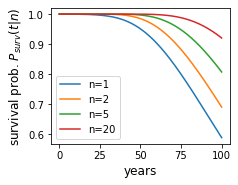

In [19]:
tau, theta = 14.5, 9
alpha = 2 * theta / tau
ts = np.linspace(0.1, 100, 500)
ns = [1, 2, 5, 20]
M_tot, n0, M_exp = 10**10, 10**4, 10**6

plt.figure(figsize=(3.2, 2.5))
plt.xlabel('years', fontsize=12)
plt.ylabel('survival prob. $P_{surv}(t | n)$', fontsize=12)
for n in ns:
    pn = p_n(n, tau, theta, n0, M_tot, M_exp)
    ps = [ftp_GBM_noise(n, t, tau, theta, n0, M_tot, M_exp) / pn for t in ts]
    p_surv = 1 - np.cumsum(ps) * (ts[1]-ts[0])
    plt.plot(ts, p_surv, label='n='+str(n))
plt.legend()

#plt.savefig('plots/gbm/marginals/p_surv.svg', facecolor='w')

### Turnover fraction

1.2413793103448276


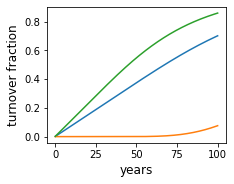

In [21]:
tau, theta = 14.5, 9
#tau, theta = 5,3
print(2*theta / tau)

plt.figure(figsize=(3.2, 2.5))
plt.xlabel('years', fontsize=12)
plt.ylabel('turnover fraction', fontsize=12)

x_bounds = [[0, np.log(M_tot)], [np.log(10**5), np.log(M_tot)], [0, np.log(1000)]]
for bounds in x_bounds:
    f = [turn_frac_density_GBM(bounds[0], bounds[1], t, tau, theta, n0, M_tot) for t in ts]
    plt.plot(ts, np.cumsum(f)*(ts[1]-ts[0]))

#plt.savefig('plots/gbm/marginals/turn_frac_tau'+str(tau)+'.svg', facecolor='w')

### Future experimental sampling given present count observation

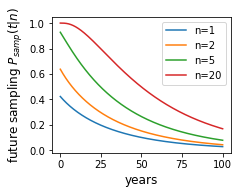

In [22]:
tau, theta = 14.5, 9

plt.figure(figsize=(3.2, 2.5))
plt.xlabel('years', fontsize=12)
plt.ylabel('future sampling $P_{samp}(t | n)$', fontsize=12)
for n in ns:
    pn = p_n(n, tau, theta, n0, M_tot, M_exp)
    ps = [p_exp_surv_GBM(n, t, tau, theta, n0, M_tot, M_exp, 1000) / pn for t in ts]
    plt.plot(ts, ps, label='n='+str(n))
plt.legend()

#plt.savefig('plots/gbm/marginals/p_exp_surv.svg', facecolor='w')

## Dependency by age

In [23]:
ages = [64, 47, 23, 39, 33]
markers = ['o', 's']
colors = ['b', 'r']
n0s = [4.2*10**5, 1.3*10**5, 4.7*10**4, 5.9*10**4, 3.1*10**4]
Ns = [6.8*10**5, 1.5*10**6, 5.1*10**6, 4.1*10**6, 8.7*10**6]

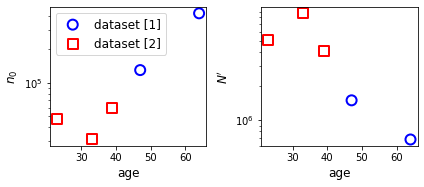

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,2.7))

ax1.set_yscale('log')
ax1.set_xlabel('age', fontsize=12)
ax1.set_ylabel(r'$n_0$', fontsize=12)
ax1.scatter(ages[:2], n0s[:2], marker=markers[0], facecolors='none', 
            edgecolors=colors[0], s=100, lw=2, label='dataset [1]')
ax1.scatter(ages[2:], n0s[2:], marker=markers[1], facecolors='none', 
            edgecolors=colors[1], s=100, lw=2, label='dataset [2]')
ax1.legend(fontsize=12)

ax2.set_yscale('log')
ax2.set_xlabel('age', fontsize=12)
ax2.set_ylabel(r"$N'$", fontsize=12)
ax2.scatter(ages[:2], Ns[:2], marker=markers[0], facecolors='none', 
            edgecolors=colors[0], s=100, lw=2, label='dataset [1]')
ax2.scatter(ages[2:], Ns[2:], marker=markers[1], facecolors='none', 
            edgecolors=colors[1], s=100, lw=2, label='dataset [2]')

plt.tight_layout()
#plt.savefig('plots/gbm/marginals/age_dependency.pdf', dpi=300, facecolor='w')